### Configuration du dataset d'entrainement et matrice de corrélation

In [5]:
# Load the 13 datasets of binetflow files and use the first 25 minutes of each dataset as training data and the rest as testing data
# Load the dataset
import pandas as pd
import glob
import os
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

# Initialize lists for train dataset
train_dfs = []

# Loop over the 13 CTU datasets
for i in range(1, 14):
    # Construct path for binetflow files
    path = f"CTU-13-Dataset/CTU-13-Dataset/{i}/"

    # Get list of all .binetflow files in the directory
    binetflow_files = glob.glob(os.path.join(path, "*.binetflow"))

    # Read and append each file
    for file in binetflow_files:
        df = pd.read_csv(file)
        df["StartTime"] = pd.to_datetime(
            df["StartTime"], format="%Y/%m/%d %H:%M:%S.%f", errors="coerce"
        )
        # Use the first 25 minutes as training data
        start_time = df["StartTime"].min()
        end_time = start_time + pd.Timedelta(minutes=25)
        train_dfs.append(
            df[(df["StartTime"] >= start_time) & (df["StartTime"] < end_time)]
        )


# Combine all train datasets into single DataFrames
train_dataset = pd.concat(train_dfs, ignore_index=True)

# Display dataset shapes
print(f"Train Dataset Shape: {train_dataset.shape}")
print("-------------------------")

# Display the first few rows of the test dataset
print(train_dataset.head())

Train Dataset Shape: (1239369, 15)
-------------------------
                   StartTime       Dur Proto        SrcAddr Sport    Dir  \
0 2011-08-10 09:46:59.607825  1.026539   tcp  94.44.127.113  1577     ->   
1 2011-08-10 09:47:00.634364  1.009595   tcp  94.44.127.113  1577     ->   
2 2011-08-10 09:47:48.185538  3.056586   tcp   147.32.86.89  4768     ->   
3 2011-08-10 09:47:48.230897  3.111769   tcp   147.32.86.89  4788     ->   
4 2011-08-10 09:47:48.963351  3.083411   tcp   147.32.86.89  4850     ->   

        DstAddr Dport State  sTos  dTos  TotPkts  TotBytes  SrcBytes  \
0  147.32.84.59  6881  S_RA   0.0   0.0        4       276       156   
1  147.32.84.59  6881  S_RA   0.0   0.0        4       276       156   
2   77.75.73.33    80  SR_A   0.0   0.0        3       182       122   
3   77.75.73.33    80  SR_A   0.0   0.0        3       182       122   
4   77.75.73.33    80  SR_A   0.0   0.0        3       182       122   

                                    Label  
0  fl

In [6]:
# Vérifier s'il y a au moins un botnet dans les données d'entraînement
train_dataset["Label"] = train_dataset["Label"].apply(lambda x: 1 if "Botnet" in x else 0)

# Vérifier si au moins un botnet est présent dans les données d'entraînement
if train_dataset["Label"].sum() > 0:
     print(f"Des botnets ont été trouvés dans les données d'entraînement. Nombre de botnets : {train_dataset['Label'].sum()}")
else:
    print("Aucun botnet n'a été trouvé dans les données d'entraînement.")

# Filtrer les lignes contenant des botnets
botnet_data = train_dataset[train_dataset["Label"] == 1]

# Regrouper les botnets par adresse IP (ici, on prend 'SrcIP' comme exemple d'adresse IP)
grouped_by_ip = botnet_data.groupby("SrcAddr").size()

# Vérifier si des botnets sont présents pour au moins une adresse IP
if grouped_by_ip.size > 0:
    print(f"Des botnets ont été trouvés dans les données d'entraînement, regroupés par adresse IP.")
    print(f"Nombre d'adresses IP avec des botnets : {grouped_by_ip.size}")
else:
    print("Aucun botnet n'a été trouvé dans les données d'entraînement.")


Des botnets ont été trouvés dans les données d'entraînement. Nombre de botnets : 11296
Des botnets ont été trouvés dans les données d'entraînement, regroupés par adresse IP.
Nombre d'adresses IP avec des botnets : 4


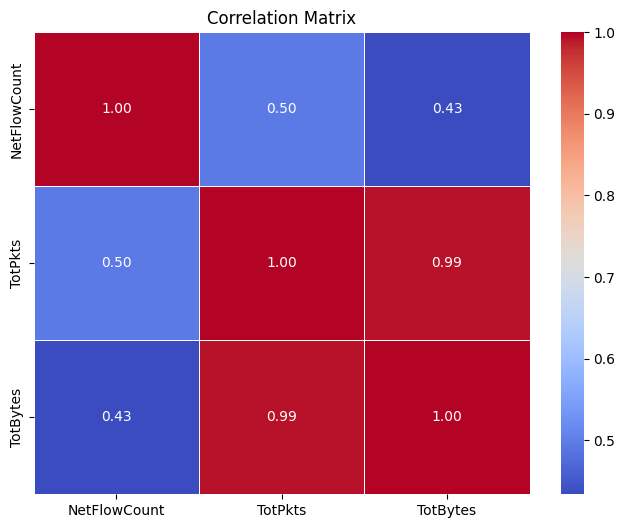

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

training_features = (
    train_dataset.groupby("SrcAddr")
    .agg(
        NetFlowCount=("SrcAddr", "count"),  # Count flows per IP
        TotBytes=("TotBytes", "sum"),  # Sum of bytes per IP
        TotPkts=("TotPkts", "sum"),  # Sum of packets per IP
    )
    .reset_index()
)

# Calculate the correlation matrix
corr_matrix = training_features[["NetFlowCount", "TotPkts", "TotBytes"]].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

### Choix du dataset de test

In [8]:
chosen_dataset = 7

In [9]:
def print_to_file(*args, file_name=f'output/dataset_{chosen_dataset}/output_dataset_{chosen_dataset}.txt'):
    os.makedirs(os.path.dirname(file_name), exist_ok=True)
    with open(file_name, 'a') as f:
        print(*args, file=f)

In [10]:
import pandas as pd
import glob
import os
import pandas as pd

# Initialize lists for test dataset
test_dfs = []


path = f"CTU-13-Dataset/CTU-13-Dataset/{chosen_dataset}/"

# Get list of all .binetflow files in the directory
binetflow_files = glob.glob(os.path.join(path, "*.binetflow"))

# Read and append each file
for file in binetflow_files:
    df = pd.read_csv(file)
    df["StartTime"] = pd.to_datetime(
        df["StartTime"], format="%Y/%m/%d %H:%M:%S.%f", errors="coerce"
    )

    ## The first 25 minutes are used for the training the data
    start_time = df["StartTime"].min()
    end_time = start_time + pd.Timedelta(minutes=25)
    
    test_dfs.append(df[df["StartTime"] >= end_time])


# Combine all train and test datasets into single DataFrames
test_dataset = pd.concat(test_dfs, ignore_index=True)

# Display dataset shapes
print_to_file(f"Train Dataset Shape: {train_dataset.shape}")
print_to_file(f"Test Dataset Shape: {test_dataset.shape}")
print_to_file("-------------------------")

# Change the labels to 1 for botnet and 0 for normal
test_dataset["Label"] = test_dataset["Label"].apply(lambda x: 1 if "Botnet" in x else 0)

# Display the first few rows of the test dataset
print_to_file("Test Dataset:")
print_to_file(test_dataset.head())
print_to_file("-------------------------\n\n")

### Matrice de confusion, métriques d'évaluation et caractérisation des faux positifs

Version avec une durée de 5 minutes pour la time window et un seuil d'anomalie de 0.0001

In [11]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- Étape 1 : Extraction des features d'entraînement ---
training_features = (
    train_dataset.groupby("SrcAddr")
    .agg(
        NetFlowCount=("SrcAddr", "count"),  
        TotBytes=("TotBytes", "sum"),  
        TotPkts=("TotPkts", "sum"),  
    )
    .reset_index()
)

# Standardisation
scaler = StandardScaler()
training_features_standardized = scaler.fit_transform(
    training_features[["NetFlowCount", "TotPkts", "TotBytes"]]
)
training_features_standardized -= training_features_standardized.mean(axis=0)

# PCA (Anomaly Detection)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(training_features_standardized)

# --- Étape 2 : Détection d'anomalies sur les données de test ---
data = test_dataset.copy()
time_window = pd.Timedelta(minutes=5)  # Taille des fenêtres temporelles
threshold = 0.0001  # Seuil d'anomalie

all_predictions = []
all_ground_truth = []
all_src_addrs = []

start_time = data["StartTime"].min()
end_time = start_time + time_window

while end_time <= data["StartTime"].max():
    window_data = data[
        (data["StartTime"] >= start_time) & (data["StartTime"] < end_time)
    ].copy()

    if window_data.empty:
        start_time = end_time
        end_time = start_time + time_window
        continue

    testing_features = window_data.groupby("SrcAddr").agg(
        NetFlowCount=("SrcAddr", "count"),
        TotBytes=("TotBytes", "sum"),
        TotPkts=("TotPkts", "sum"),
        is_botnet=("Label", "max"),
    ).reset_index()

    # Standardiser avec le scaler entraîné
    if not testing_features.empty:
        testing_features_standardized = scaler.transform(
            testing_features[["NetFlowCount", "TotPkts", "TotBytes"]]
        )
        testing_features_standardized -= testing_features_standardized.mean(axis=0)

        ground_truth = testing_features["is_botnet"].values

        # Reconstruction PCA et score d'anomalie
        X_reconstructed = pca.inverse_transform(
            pca.transform(testing_features_standardized)
        )
        residuals = np.abs(testing_features_standardized - X_reconstructed)
        anomaly_score = np.linalg.norm(residuals, axis=1) ** 2

        # Normalisation
        anomaly_score = (anomaly_score - anomaly_score.min()) / (
            anomaly_score.max() - anomaly_score.min() + 1e-10
        )

        predictions = anomaly_score > threshold  # Détection des anomalies

        # Stocker les résultats
        all_predictions.extend(predictions)
        all_ground_truth.extend(ground_truth)
        all_src_addrs.extend(testing_features["SrcAddr"].values)

    # Avancer la fenêtre temporelle
    start_time = end_time
    end_time = start_time + time_window

# Créer un DataFrame avec les résultats
results_df = pd.DataFrame({
    "SrcAddr": all_src_addrs,
    "Predicted": all_predictions,
    "GroundTruth": all_ground_truth
})

# --- Étape 3 : Analyse comparative Faux Positifs vs Trafic Normal ---

# Identifier les faux positifs
false_positives = results_df[(results_df["Predicted"] == 1) & (results_df["GroundTruth"] == 0)]
normal_traffic = results_df[(results_df["GroundTruth"] == 0)]  # Tout le trafic normal (inclut les vrais négatifs et faux positifs)

if not false_positives.empty:
    # Statistiques des faux positifs
    fp_stats = test_dataset[test_dataset["SrcAddr"].isin(false_positives["SrcAddr"])] \
        .groupby("SrcAddr") \
        .agg(
            NetFlowCount=("SrcAddr", "count"),
            AvgBytesPerFlow=("TotBytes", "mean"),
            AvgPktsPerFlow=("TotPkts", "mean"),
            TotalBytes=("TotBytes", "sum"),
            TotalPkts=("TotPkts", "sum")
        ).reset_index()
    
    # Statistiques du trafic normal (moyennes)
    normal_stats = test_dataset[test_dataset["SrcAddr"].isin(normal_traffic["SrcAddr"])] \
        .groupby("SrcAddr") \
        .agg(
            NetFlowCount=("SrcAddr", "count"),
            AvgBytesPerFlow=("TotBytes", "mean"),
            AvgPktsPerFlow=("TotPkts", "mean"),
            TotalBytes=("TotBytes", "sum"),
            TotalPkts=("TotPkts", "sum")
        ).reset_index()
    
    # Échantillonner pour l'affichage
    fp_sample = fp_stats.sample(min(100, len(fp_stats)), random_state=42)
    normal_sample = normal_stats.sample(min(1000, len(normal_stats)), random_state=42)
    
    # Affichage comparatif
    print_to_file("\n=== COMPARAISON FAUX POSITIFS vs TRAFIC NORMAL ===")
    print_to_file("\nCaracteristiques des faux positifs (echantillon) :")
    print_to_file(fp_sample.describe())
    
    print_to_file("\nCaracteristiques du trafic normal (echantillon) :")
    print_to_file(normal_sample.describe())
    
    # Visualisation comparative
    plt.figure(figsize=(15, 10))
    
    # Comparaison NetFlowCount
    plt.subplot(2, 2, 1)
    sns.boxplot(data=[fp_stats["NetFlowCount"], normal_stats["NetFlowCount"]],
                showfliers=False)
    plt.xticks([0, 1], ["Faux Positifs", "Trafic Normal"])
    plt.title("Nombre de flux par adresse source")
    plt.ylabel("Count")
    
    # Comparaison AvgBytesPerFlow
    plt.subplot(2, 2, 2)
    sns.boxplot(data=[fp_stats["AvgBytesPerFlow"], normal_stats["AvgBytesPerFlow"]],
                showfliers=False)
    plt.xticks([0, 1], ["Faux Positifs", "Trafic Normal"])
    plt.title("Taille moyenne des flux (bytes)")
    plt.ylabel("Bytes")
    
    # Comparaison AvgPktsPerFlow
    plt.subplot(2, 2, 3)
    sns.boxplot(data=[fp_stats["AvgPktsPerFlow"], normal_stats["AvgPktsPerFlow"]],
                showfliers=False)
    plt.xticks([0, 1], ["Faux Positifs", "Trafic Normal"])
    plt.title("Nombre moyen de paquets par flux")
    plt.ylabel("Packets")
    
    # Comparaison TotalBytes
    plt.subplot(2, 2, 4)
    sns.boxplot(data=[fp_stats["TotalBytes"], normal_stats["TotalBytes"]],
                showfliers=False)
    plt.xticks([0, 1], ["Faux Positifs", "Trafic Normal"])
    plt.title("Volume total par adresse source")
    plt.ylabel("Bytes")
    
    plt.tight_layout()
    plt.savefig(f'output/dataset_{chosen_dataset}/comparisons_dataset_{chosen_dataset}.png')
    
    # Test statistique (exemple avec le nombre de flux)
    print_to_file("\n\n-------------------------")
    print_to_file("=== TEST STATISTIQUE ===\n")
    print_to_file("Test de Mann-Whitney pour NetFlowCount entre faux positifs et trafic normal\n")
    from scipy.stats import mannwhitneyu
    stat, p = mannwhitneyu(fp_stats["NetFlowCount"], normal_stats["NetFlowCount"])
    print_to_file(f"\nTest de Mann-Whitney pour NetFlowCount: p-value={p:.12f}")
    print_to_file("Les distributions sont significativement differentes." if p < 0.05 else "Pas de difference significative.")
    
else:
    print_to_file("Aucun faux positif détecté - pas de comparaison possible.")

# --- Étape 4 : Calcul des métriques ---
TP = np.sum((results_df["Predicted"] == 1) & (results_df["GroundTruth"] == 1))
FP = np.sum((results_df["Predicted"] == 1) & (results_df["GroundTruth"] == 0))
TN = np.sum((results_df["Predicted"] == 0) & (results_df["GroundTruth"] == 0))
FN = np.sum((results_df["Predicted"] == 0) & (results_df["GroundTruth"] == 1))

TPR = TP / (TP + FN) if (TP + FN) != 0 else 0
FPR = FP / (FP + TN) if (FP + TN) != 0 else 0
Precision = TP / (TP + FP) if (TP + FP) != 0 else 0
Recall = TP / (TP + FN) if (TP + FN) != 0 else 0
F1_Score = (
    2 * (Precision * Recall) / (Precision + Recall) if (Precision + Recall) != 0 else 0
)

print_to_file(f"TPR: {TPR:.4f}, FPR: {FPR:.4f}, Precision: {Precision:.4f}, Recall: {Recall:.4f}, F1 Score: {F1_Score:.4f}")

# --- Étape 5 : Affichage de la matrice de confusion ---
cm = confusion_matrix(results_df["GroundTruth"], results_df["Predicted"])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig(f'output/dataset_{chosen_dataset}/confusion_matrix_dataset_{chosen_dataset}.png')

ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 800x600 with 0 Axes>

### Recherche de seuil optimal

c:\Users\tomab\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\tomab\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: x and y must have same first dimension, but have shapes (100,) and (1,)

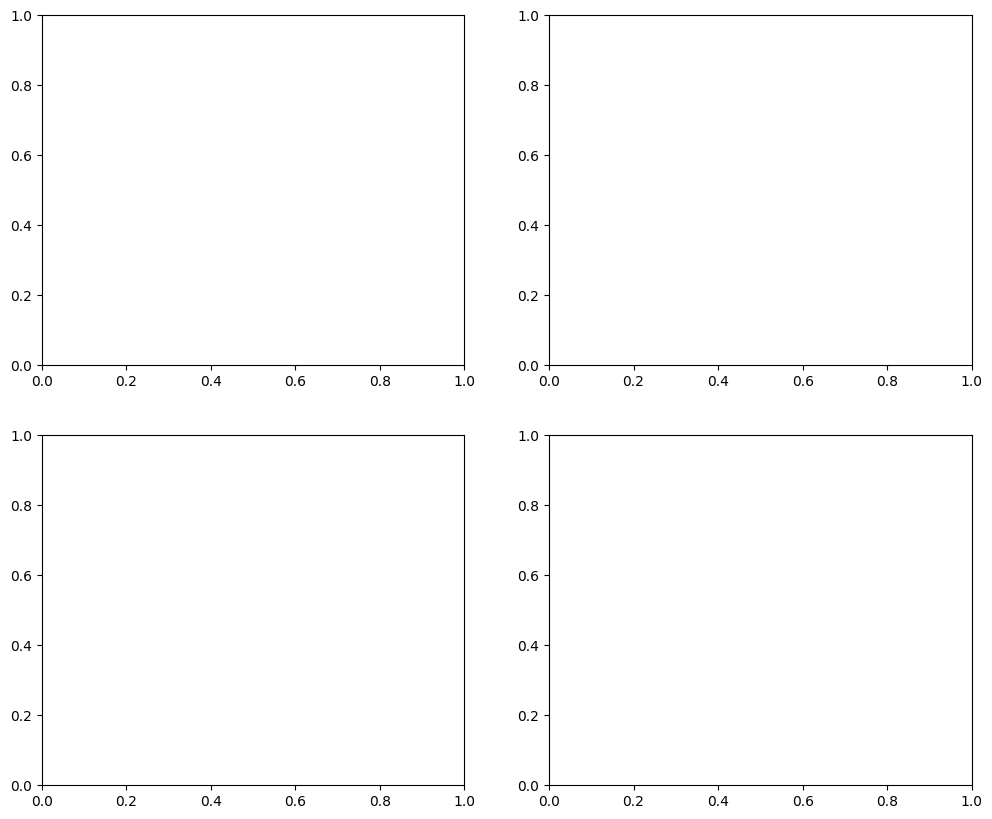

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score

training_features = (
    train_dataset.groupby("SrcAddr")
    .agg(
        NetFlowCount=("SrcAddr", "count"),  # Count flows per IP
        TotBytes=("TotBytes", "sum"),  # Sum of bytes per IP
        TotPkts=("TotPkts", "sum"),  # Sum of packets per IP
    )
    .reset_index()
)

# Standardize features
scaler = StandardScaler()
training_features_standardized = scaler.fit_transform(
    training_features[["NetFlowCount", "TotPkts", "TotBytes"]]
)
training_features_standardized -= training_features_standardized.mean(
    axis=0
)  # Mean-centering

# Anomaly Detectors: Lakhina Volume using PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(training_features_standardized)

# _______________________________________________________________________________________________________________________

data = test_dataset
# Define the time window for testing (25 minutes)
time_window = pd.Timedelta(minutes=5)

# Initialize variables for storing results
thresholds = np.linspace(0.0001, 0.2, 100)

TP_list, FP_list, TN_list, FN_list, f1_scores = [], [], [], [], []

# Iterate over the data in 25-minute windows
start_time = data["StartTime"].min()
end_time = start_time + time_window

while end_time <= data["StartTime"].max():
    window_data = data[
        (data["StartTime"] >= start_time) & (data["StartTime"] < end_time)
    ]

    if window_data.empty:
        break

    testing_features = window_data.groupby("SrcAddr").agg(
        NetFlowCount=("SrcAddr", "count"),
        TotBytes=("TotBytes", "sum"),
        TotPkts=("TotPkts", "sum"),
        is_botnet=("Label", "max"),
    )
    scaler = StandardScaler()
    # Standardize testing features using the same scaler
    testing_features_standardized = scaler.fit_transform(
        testing_features[["NetFlowCount", "TotPkts", "TotBytes"]]
    )
    testing_features_standardized -= testing_features_standardized.mean(
        axis=0
    )  # Mean-centering
    ground_truth = testing_features["is_botnet"].values

    X_reconstructed = pca.inverse_transform(
        pca.transform(testing_features_standardized)
    )

    residuals = np.abs(testing_features_standardized - X_reconstructed)
    anomaly_score = np.linalg.norm(residuals, axis=1) ** 2  # Squared Prediction Error
    anomaly_score = (anomaly_score - anomaly_score.min()) / (
        anomaly_score.max() - anomaly_score.min()
    )

    # Calcul des métriques pour chaque seuil
    TP_temp, FP_temp, TN_temp, FN_temp, f1_temp = [], [], [], [], []
    for threshold in thresholds:
        predictions = anomaly_score > threshold
        TP_temp.append(np.sum((predictions == 1) & (ground_truth == 1)))
        FP_temp.append(np.sum((predictions == 1) & (ground_truth == 0)))
        TN_temp.append(np.sum((predictions == 0) & (ground_truth == 0)))
        FN_temp.append(np.sum((predictions == 0) & (ground_truth == 1)))

        # Calculate the F1 score for the threshold
        f1_temp.append(f1_score(ground_truth, predictions))

    # Ajouter les valeurs moyennes de la fenêtre à la liste globale
    TP_list.append(TP_temp)
    FP_list.append(FP_temp)
    TN_list.append(TN_temp)
    FN_list.append(FN_temp)
    f1_scores.append(f1_temp)

    # Move to the next time window
    start_time = end_time
    end_time = start_time + time_window

# Conversion en tableau numpy pour pouvoir moyenner sur toutes les fenêtres
TP_list = np.mean(np.array(TP_list), axis=0)
FP_list = np.mean(np.array(FP_list), axis=0)
TN_list = np.mean(np.array(TN_list), axis=0)
FN_list = np.mean(np.array(FN_list), axis=0)
f1_scores = np.mean(np.array(f1_scores), axis=0)

# Determine the optimal threshold (max F1 score)
optimal_threshold_index = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_threshold_index]

# Plot the results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# True Positives
axes[0, 0].plot(thresholds, TP_list, color='green')
axes[0, 0].set_title("True Positives (TP)")
axes[0, 0].set_xlabel("Threshold")
axes[0, 0].set_ylabel("Count")
axes[0, 0].grid()

# False Positives
axes[0, 1].plot(thresholds, FP_list, color='red')
axes[0, 1].set_title("False Positives (FP)")
axes[0, 1].set_xlabel("Threshold")
axes[0, 1].set_ylabel("Count")
axes[0, 1].grid()

# True Negatives
axes[1, 0].plot(thresholds, TN_list, color='blue')
axes[1, 0].set_title("True Negatives (TN)")
axes[1, 0].set_xlabel("Threshold")
axes[1, 0].set_ylabel("Count")
axes[1, 0].grid()

# False Negatives
axes[1, 1].plot(thresholds, FN_list, color='orange')
axes[1, 1].set_title("False Negatives (FN)")
axes[1, 1].set_xlabel("Threshold")
axes[1, 1].set_ylabel("Count")
axes[1, 1].grid()

plt.tight_layout()
plt.savefig(f'output/dataset_{chosen_dataset}/metrics_for_threshold_dataset_{chosen_dataset}.png')

print_to_file("\n\n-------------------------")
# Display the optimal threshold and the corresponding F1 score
print_to_file(f"Optimal Threshold: {optimal_threshold}")
print_to_file(f"Maximum F1 Score: {f1_scores[optimal_threshold_index]}")

print_to_file("-------------------------\n\n")


### Analyse de performance selon la durée de la time window

1.0
1.6428571428571428
2.2857142857142856
2.928571428571429
3.5714285714285716
4.214285714285714
4.857142857142858
5.5
6.142857142857143
6.7857142857142865
7.428571428571429
8.071428571428573
8.714285714285715
9.357142857142858
10.0


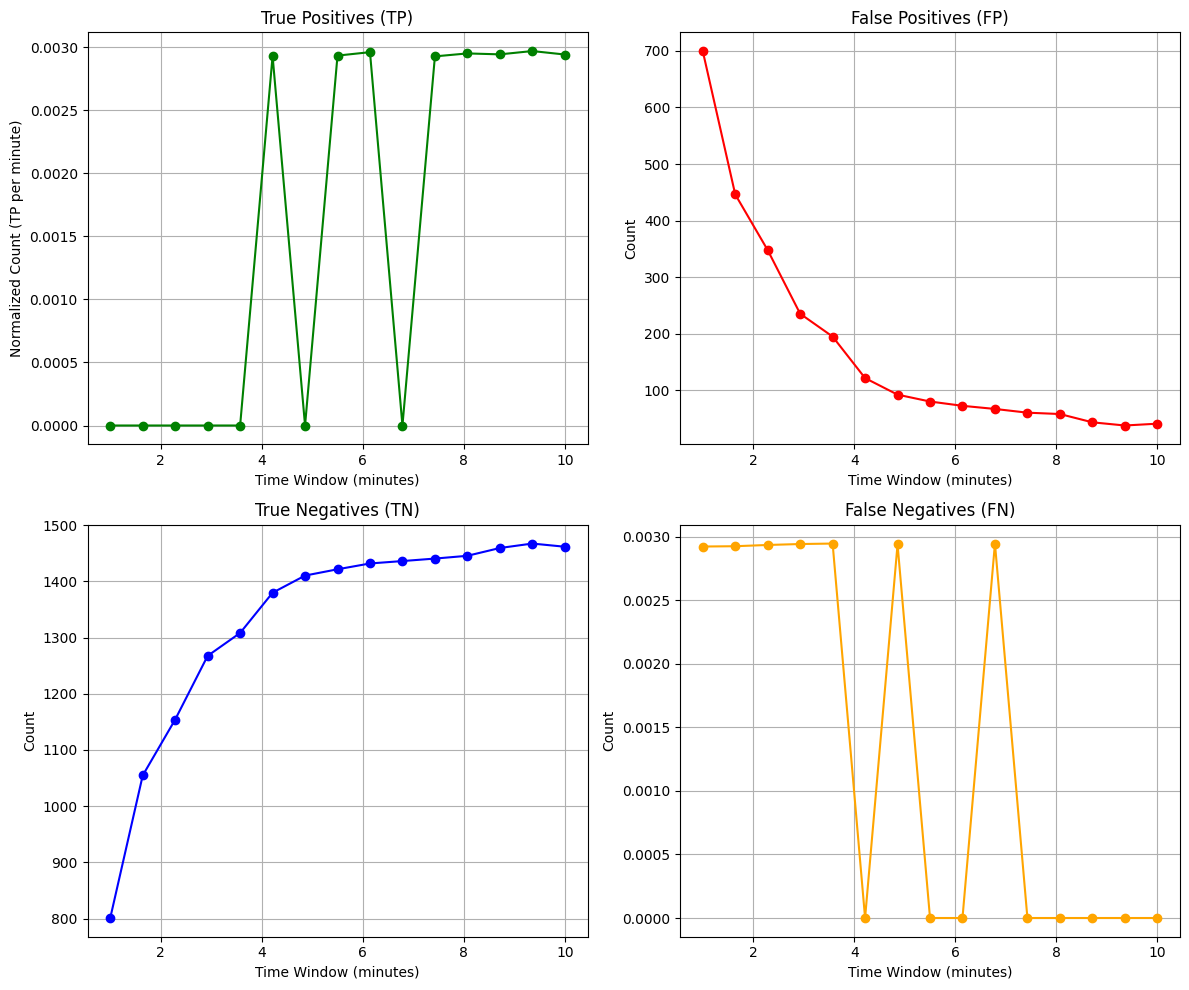

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Entraînement du modèle PCA
training_features = (
    train_dataset.groupby("SrcAddr")
    .agg(
        NetFlowCount=("SrcAddr", "count"),
        TotBytes=("TotBytes", "sum"),
        TotPkts=("TotPkts", "sum"),
    )
    .reset_index()
)

scaler = StandardScaler()
training_features_standardized = scaler.fit_transform(
    training_features[["NetFlowCount", "TotPkts", "TotBytes"]]
)
training_features_standardized -= training_features_standardized.mean(axis=0)

pca = PCA(n_components=2)
pca.fit(training_features_standardized)  # Ajuster le modèle PCA

# _______________________________________________________________________________________________________________________

data = test_dataset
threshold = 0.00001  # Seuil fixe

time_windows = np.linspace(0.1, 10, 30) # Différentes tailles de fenêtres en minutes
TP_list, FP_list, TN_list, FN_list = [], [], [], []

for tw in time_windows:
    print(tw)
    time_window = pd.Timedelta(minutes=tw)
    
    TP_sum, FP_sum, TN_sum, FN_sum = 0, 0, 0, 0
    count_windows = 0  # Nombre total de fenêtres analysées
    
    seen_ips = set()  # Stocke les IPs déjà analysées pour éviter de les recalculer

    start_time = data["StartTime"].min()
    end_time = start_time + time_window

    while end_time <= data["StartTime"].max():
        # print_to_file(end_time)
        window_data = data[
            (data["StartTime"] >= start_time) & (data["StartTime"] < end_time)
        ]

        if not window_data.empty:
            # Filtrer les IPs déjà analysées
            window_data = window_data[~window_data["SrcAddr"].isin(seen_ips)]

            if not window_data.empty:
                testing_features = window_data.groupby("SrcAddr").agg(
                    NetFlowCount=("SrcAddr", "count"),
                    TotBytes=("TotBytes", "sum"),
                    TotPkts=("TotPkts", "sum"),
                    is_botnet=("Label", "max"),
                )

                # Ajouter les nouvelles IPs vues à la liste
                seen_ips.update(testing_features.index)

                # Standardiser avec le même scaler
                testing_features_standardized = scaler.transform(
                    testing_features[["NetFlowCount", "TotPkts", "TotBytes"]]
                )
                testing_features_standardized -= testing_features_standardized.mean(axis=0)

                ground_truth = testing_features["is_botnet"].values

                # Reconstruction via PCA
                X_reconstructed = pca.inverse_transform(
                    pca.transform(testing_features_standardized)
                )

                residuals = np.abs(testing_features_standardized - X_reconstructed)
                anomaly_score = np.linalg.norm(residuals, axis=1) ** 2  # Squared Prediction Error
                anomaly_score = (anomaly_score - anomaly_score.min()) / (
                    anomaly_score.max() - anomaly_score.min()
                )

                # Prédictions avec le seuil fixe
                predictions = anomaly_score > threshold

                TP_sum += np.sum((predictions == 1) & (ground_truth == 1))
                FP_sum += np.sum((predictions == 1) & (ground_truth == 0))
                TN_sum += np.sum((predictions == 0) & (ground_truth == 0))
                FN_sum += np.sum((predictions == 0) & (ground_truth == 1))

                count_windows += 1

        # Passer à la fenêtre suivante
        start_time = end_time
        end_time = start_time + time_window

    # Moyenne des valeurs sur toutes les fenêtres
    TP_list.append(TP_sum / count_windows if count_windows > 0 else 0)
    FP_list.append(FP_sum / count_windows if count_windows > 0 else 0)
    TN_list.append(TN_sum / count_windows if count_windows > 0 else 0)
    FN_list.append(FN_sum / count_windows if count_windows > 0 else 0)

# Tracé des courbes en fonction de la taille de la fenêtre
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# True Positives
axes[0, 0].plot(time_windows, np.array(TP_list) / np.array(time_windows), color='green', marker='o')
axes[0, 0].set_title("True Positives (TP)")
axes[0, 0].set_xlabel("Time Window (minutes)")
axes[0, 0].set_ylabel("Normalized Count (TP per minute)")
axes[0, 0].grid()

# False Positives
axes[0, 1].plot(time_windows, np.array(FP_list) / np.array(time_windows), color='red', marker='o')
axes[0, 1].set_title("False Positives (FP)")
axes[0, 1].set_xlabel("Time Window (minutes)")
axes[0, 1].set_ylabel("Count")
axes[0, 1].grid()

# True Negatives
axes[1, 0].plot(time_windows, np.array(TN_list) / np.array(time_windows), color='blue', marker='o')
axes[1, 0].set_title("True Negatives (TN)")
axes[1, 0].set_xlabel("Time Window (minutes)")
axes[1, 0].set_ylabel("Count")
axes[1, 0].grid()

# False Negatives
axes[1, 1].plot(time_windows, np.array(FN_list) / np.array(time_windows), color='orange', marker='o')
axes[1, 1].set_title("False Negatives (FN)")
axes[1, 1].set_xlabel("Time Window (minutes)")
axes[1, 1].set_ylabel("Count")
axes[1, 1].grid()

plt.tight_layout()
plt.savefig(f'output/dataset_{chosen_dataset}/metrics_for_time_window_dataset_{chosen_dataset}.png')
